## Let's start looking at the communicative context of calls. 
## - Cluster 2 or 3 calls at a time, instead of just 1
## - Start by looking at the intervals between calls
## - I've clustered calls into categories in two different ways and I need to combine them or whatever
## - The biosound H5 files don't have this info, so I'll be extracting it from the soundsep segment filenames


In [7]:
# from scipy import integrate, optimize

import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

In [16]:
# we have wav files in a folder, H5 files in a folder, and soundsep data. 

base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/'

soundsep_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
wave_files_folder = os.path.join(base_folder,'wavs')
spectrogram_folder = os.path.join(base_folder,'spec_results')

# Load the soundsep data
print(soundsep_file_name)
df = pd.read_csv(soundsep_file_name, sep=',',header=0)        
print(f'Length of dataframe: {len(df)}')
print(f'Column names: {df.columns}')
print(f'Tags: {df["Tags"].unique()}')

# Load the wav filenames to compare with the soundsep data for consistency.
wav_list = [f for f in os.listdir(os.path.join(base_folder,'wavs')) if f.endswith('.wav')]
wav_lengths = [read(os.path.join(base_folder,'wavs',f))[1].shape[0] for f in wav_list]  
shortest_file = wav_list[np.argmin(wav_lengths)]
fs, data = read(os.path.join(base_folder,'wavs', shortest_file))

# Load the spectrogram data to compare with the soundsep data for consistency.
spec_cluster_labels = np.load(os.path.join(base_folder,'spec_results','cluster_labels.npy'))


/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv
Length of dataframe: 4344
Column names: Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags', 'cluster', 'coords'],
      dtype='object')
Tags: ['["tet"]' '["hat"]' '["3"]' '["call"]' '["DC"]' '["WF"]' '["-2"]' '["8"]'
 '["2"]']


In [17]:
# let's at least make sure the wav files are in the same order as the soundsep data
# we'll just check that the lengths of the wav files are the same as the lengths of the soundsep data
# and that the names are the same (maybe) 
# and that the spectrogram data is the same length as the soundsep data (maybe)

if len(df) != len(wav_list):
    print('Dataframe length does not match wav file length')
    print(f'Length of dataframe: {len(df)}')
    print(f'Length of wav files: {len(wav_list)}')
else:
    print('Dataframe length matches wav file length')

if len(df) != len(cluster_labels):
    print('Dataframe length does not match cluster label length')
    print(f'Length of dataframe: {len(df)}')
    print(f'Length of cluster labels: {len(cluster_labels)}')
else:
    print('Dataframe length matches cluster label length')

# TODO - check that the wav files are in the same order as the soundsep data
# TODO - check that the wav files are in the same order as the cluster labels



Dataframe length matches wav file length
Dataframe length matches cluster label length


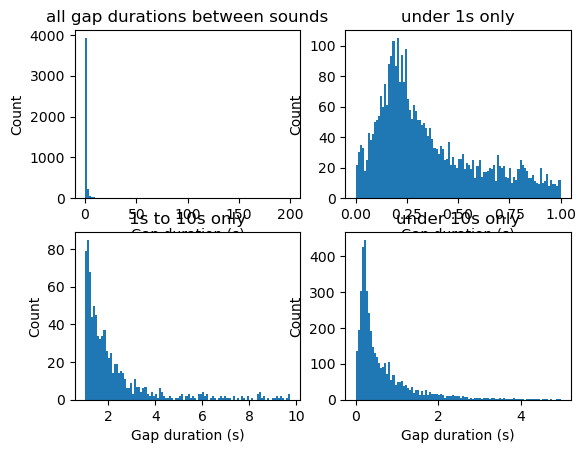

In [18]:
# calculate the gap durations between each sound
# we'll use the soundsep data for this
# df['StartIndex'][0]
df['gap_duration'] = df['StartIndex'].diff()
df['gap_duration'] /= fs

# plot a histogram of the gap durations

plt.figure()
plt.subplot(2,2,1)
plt.hist(df['gap_duration'], bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('all gap durations between sounds')

# plot a histogram of the gap durations zoomed in on the short gaps
# take the gap_durations that are less than 1 second and put them in a variable to make a histogram
short_gap_index = (df['gap_duration'] < 1).values
short_gaps = df['gap_duration'][short_gap_index]
plt.subplot(2,2,2)
plt.hist(short_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('under 1s only')

medium_gap_index = (df['gap_duration'] > 1) & (df['gap_duration'] < 10)
medium_gaps = df['gap_duration'][medium_gap_index]
plt.subplot(2,2,3)
plt.hist(medium_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('1s to 10s only')

shortish_gap_index = (df['gap_duration']  < 5)
shortish_gaps = df['gap_duration'][shortish_gap_index]
plt.subplot(2,2,4)
plt.hist(shortish_gaps, bins=100)
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('under 10s only')

plt.show()


# Ok that's surprisingly interesting already.
## I want to calculate which call types follow which call types and what the durations are between different types of call types

Call type: 0


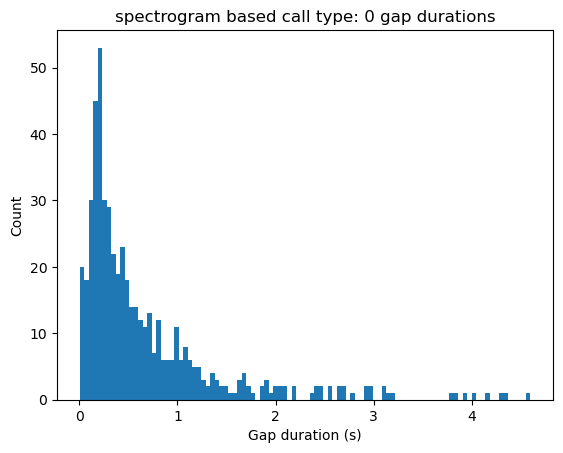

Call type: 1


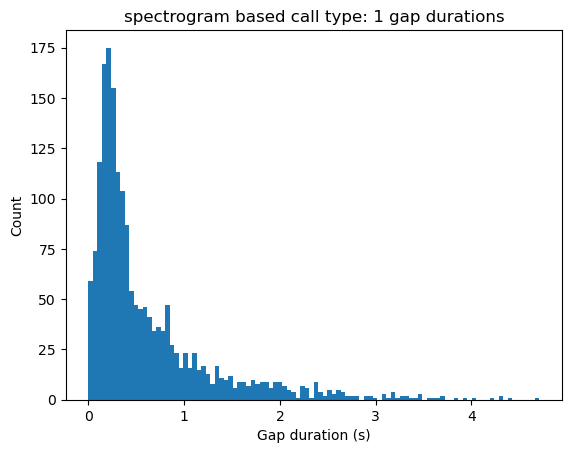

Call type: 2


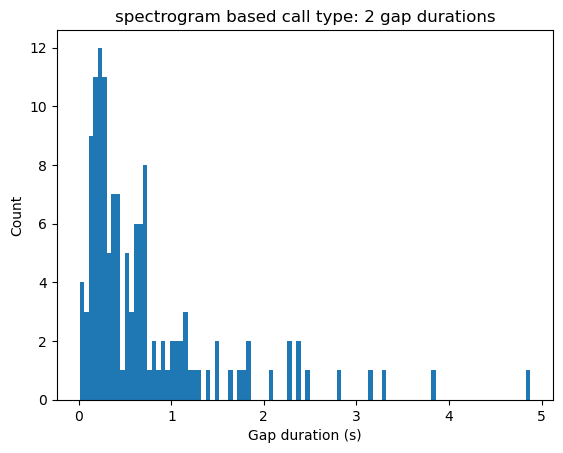

Call type: 3


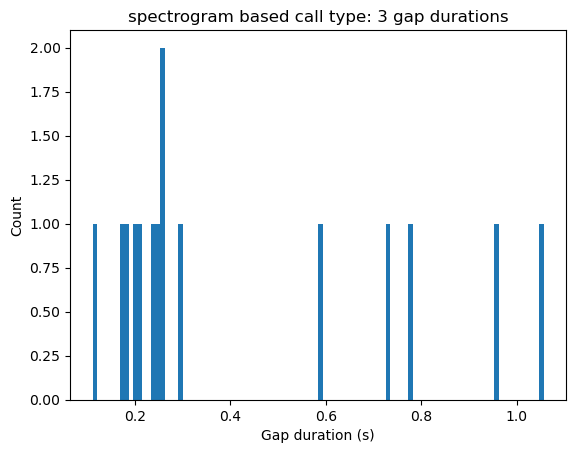

Call type: 4


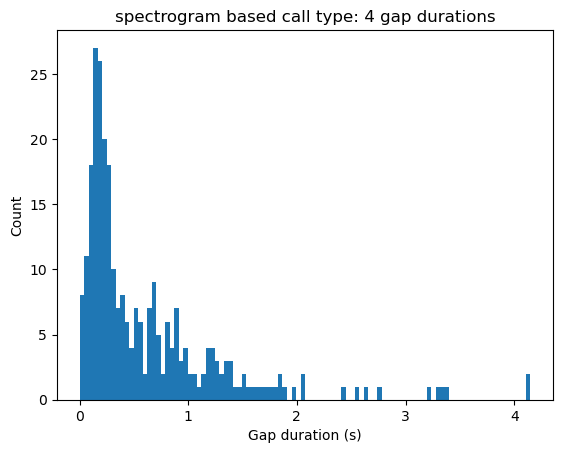

Call type: 5


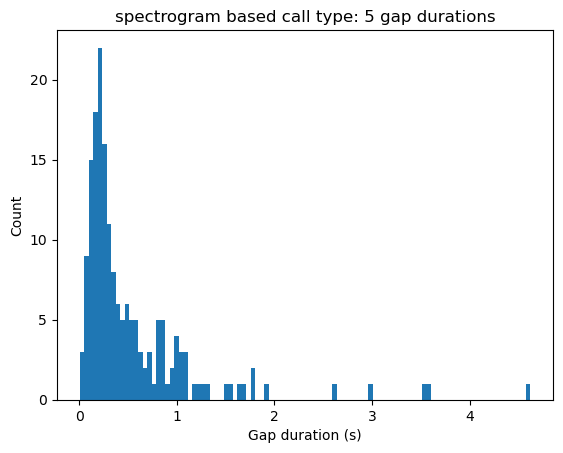

Call type: 6


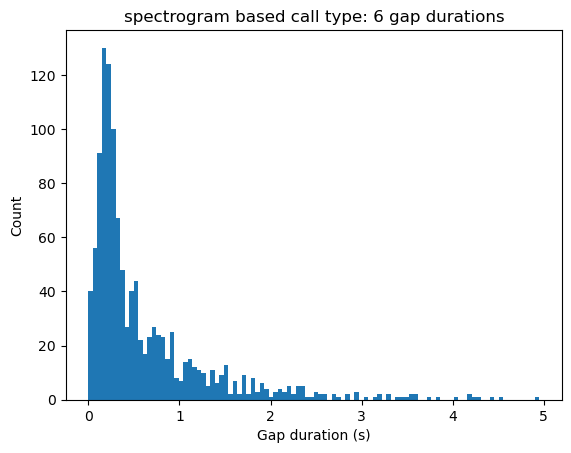

In [19]:
for call_type in np.unique(cluster_labels):
    print(f'Call type: {call_type}')
    call_index = (cluster_labels == call_type)
    call_index = call_index & (df['gap_duration'] < 5)
    call_gaps = df['gap_duration'][call_index]
    plt.figure()
    plt.hist(call_gaps, bins=100)
    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'spectrogram based call type: {call_type} gap durations')
    plt.show()

Call type: ["-2"]


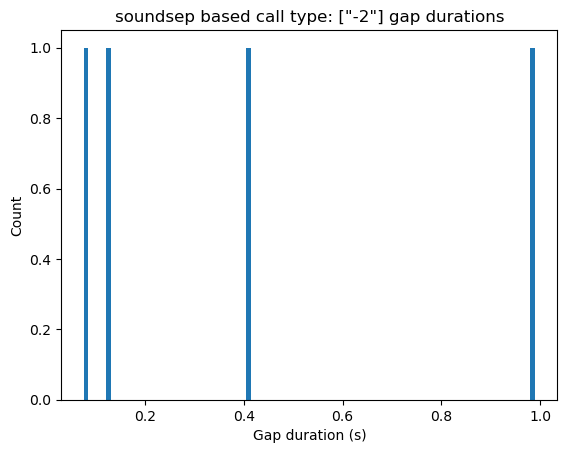

Call type: ["2"]


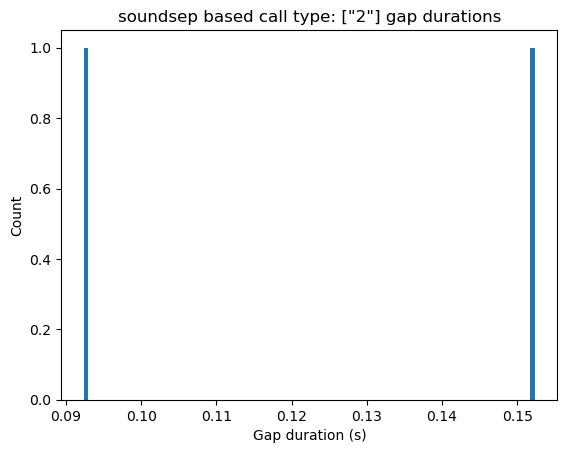

Call type: ["3"]


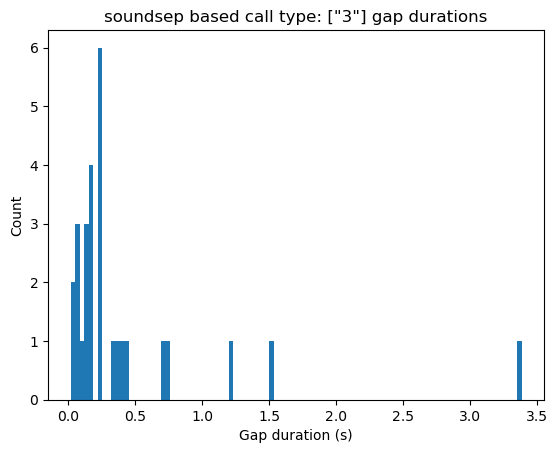

Call type: ["8"]


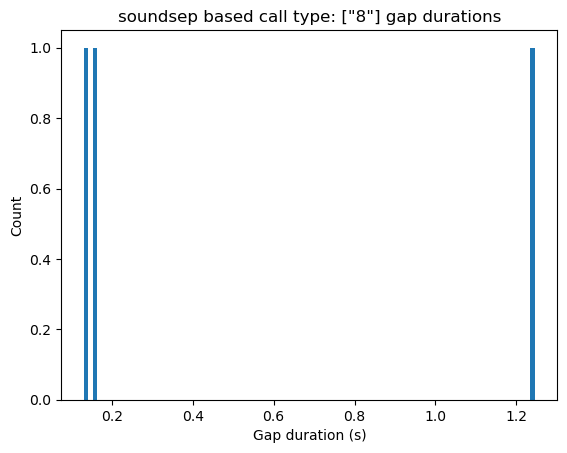

Call type: ["DC"]


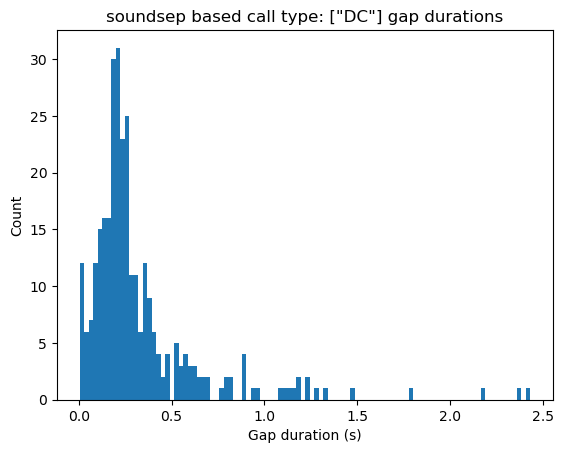

Call type: ["WF"]


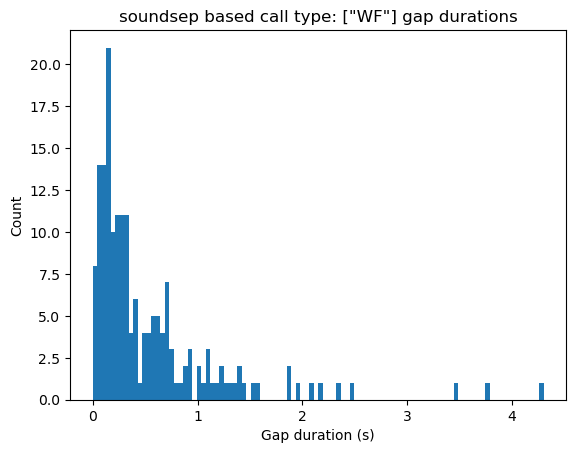

Call type: ["call"]


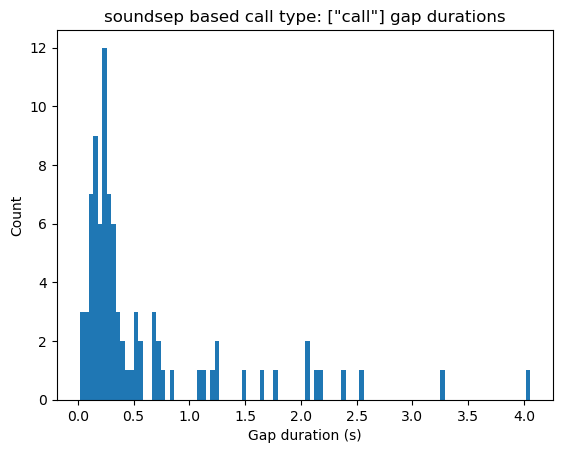

Call type: ["hat"]


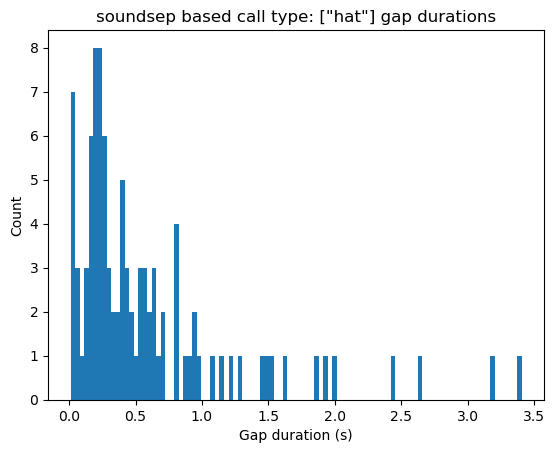

Call type: ["tet"]


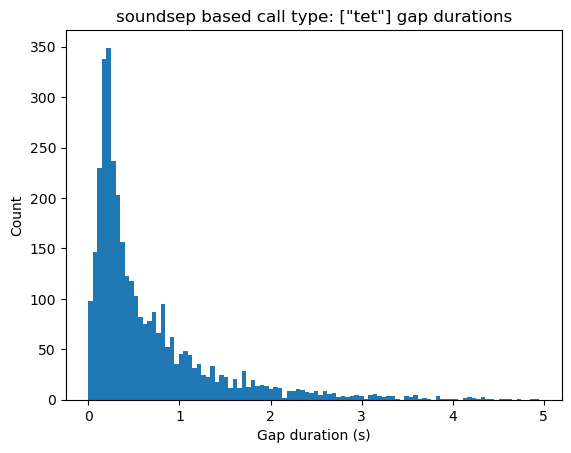

In [20]:
# do the same thing with the labels from the soundsep data
for call_type in np.unique(df['Tags']):
    print(f'Call type: {call_type}')
    call_index = (df['Tags'] == call_type)
    call_index = call_index & (df['gap_duration'] < 5)
    call_gaps = df['gap_duration'][call_index]
    plt.figure()
    plt.hist(call_gaps, bins=100)
    plt.xlabel('Gap duration (s)')
    plt.ylabel('Count')
    plt.title(f'soundsep based call type: {call_type} gap durations')
    plt.show()

In [70]:
print(df['Tags'][0])
# print the first Tag in the dataframe
if df['Tags'][0] == '["tet"]':
    print('First tag is tet')

["tet"]
First tag is tet


In [73]:
gap_duration_dict = {bird: [] for bird in birds}
gap_duration_dict['BluGre1214F'] = {bird: [] for bird in birds}
gap_duration_dict['BroGre1354M'] = {bird: [] for bird in birds}
gap_duration_dict['WhiWhi1541M'] = {bird: [] for bird in birds}
gap_duration_dict['WhiWhi6607F'] = {bird: [] for bird in birds}

# initialize lists for each bird pair
gap_duration_dict['BluGre1214F']['BluGre1214F'] = list()
gap_duration_dict['BluGre1214F']['BroGre1354M'] = list()
gap_duration_dict['BluGre1214F']['WhiWhi1541M'] = list()
gap_duration_dict['BluGre1214F']['WhiWhi6607F'] = list()
gap_duration_dict['BroGre1354M']['BluGre1214F'] = list()
gap_duration_dict['BroGre1354M']['BroGre1354M'] = list()
gap_duration_dict['BroGre1354M']['WhiWhi1541M'] = list()
gap_duration_dict['BroGre1354M']['WhiWhi6607F'] = list()
gap_duration_dict['WhiWhi1541M']['BluGre1214F'] = list()
gap_duration_dict['WhiWhi1541M']['BroGre1354M'] = list()
gap_duration_dict['WhiWhi1541M']['WhiWhi1541M'] = list()
gap_duration_dict['WhiWhi1541M']['WhiWhi6607F'] = list()
gap_duration_dict['WhiWhi6607F']['BluGre1214F'] = list()
gap_duration_dict['WhiWhi6607F']['BroGre1354M'] = list()
gap_duration_dict['WhiWhi6607F']['WhiWhi1541M'] = list()
gap_duration_dict['WhiWhi6607F']['WhiWhi6607F'] = list()

for i in range(len(df)-1):
    if df['Tags'][i] == '["tet"]':
        vocalizer = df['SourceName'][i]
        responder = df['SourceName'][i+1]
        response = df['Tags'][i+1]
        if response == '["tet"]':
            gap_duration = (df['StopIndex'][i]-df['StartIndex'][i])/fs
            gap_duration_dict[vocalizer][responder].append(gap_duration)

gap_duration_dict

{'BroGre1354M': {'BroGre1354M': [0.09466666666666666,
   0.08229166666666667,
   0.09416666666666666,
   0.092625,
   0.07833333333333334,
   0.07904166666666666,
   0.07497916666666667,
   0.09727083333333333,
   0.07535416666666667,
   0.1053125,
   0.37285416666666665,
   0.0879375,
   0.058854166666666666,
   0.09089583333333333,
   0.09845833333333333,
   0.09658333333333333,
   0.0841875,
   0.09810416666666667,
   0.09591666666666666,
   0.10597916666666667,
   0.09316666666666666,
   0.02666666666666667,
   0.08872916666666666,
   0.059625,
   0.097125,
   0.060833333333333336,
   0.10197916666666666,
   0.09629166666666666,
   0.10095833333333333,
   0.11904166666666667,
   0.08452083333333334,
   0.11535416666666666,
   0.12041666666666667,
   0.09422916666666667,
   0.1115,
   0.073375,
   0.08772916666666666,
   0.082,
   0.02975,
   0.087125,
   0.09145833333333334,
   0.07927083333333333,
   0.10679166666666666,
   0.06525,
   0.06525,
   0.1025625,
   0.11072916666666667

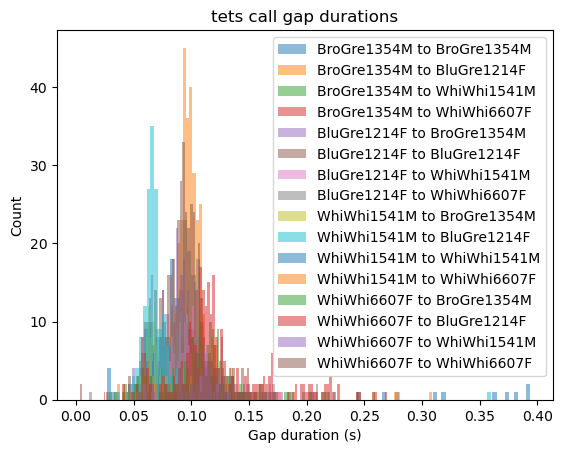

In [74]:
# I want to focus on tets (soundsep based) and look at how quickly birds are calling after each other
# I want to look at the gap durations between tets calls
# let's plot the gap durations between tets calls of different individuals vs the gap durations between tets calls of the same individual
# first, let's get the gap durations between tet calls of all individuals and stick them in a dictionary of dictionaries of lists
birds = df['SourceName'].unique()

gap_duration_dict = {bird: [] for bird in birds}
gap_duration_dict['BluGre1214F'] = {bird: [] for bird in birds}
gap_duration_dict['BroGre1354M'] = {bird: [] for bird in birds}
gap_duration_dict['WhiWhi1541M'] = {bird: [] for bird in birds}
gap_duration_dict['WhiWhi6607F'] = {bird: [] for bird in birds}

# initialize lists for each bird pair
gap_duration_dict['BluGre1214F']['BluGre1214F'] = list()
gap_duration_dict['BluGre1214F']['BroGre1354M'] = list()
gap_duration_dict['BluGre1214F']['WhiWhi1541M'] = list()
gap_duration_dict['BluGre1214F']['WhiWhi6607F'] = list()
gap_duration_dict['BroGre1354M']['BluGre1214F'] = list()
gap_duration_dict['BroGre1354M']['BroGre1354M'] = list()
gap_duration_dict['BroGre1354M']['WhiWhi1541M'] = list()
gap_duration_dict['BroGre1354M']['WhiWhi6607F'] = list()
gap_duration_dict['WhiWhi1541M']['BluGre1214F'] = list()
gap_duration_dict['WhiWhi1541M']['BroGre1354M'] = list()
gap_duration_dict['WhiWhi1541M']['WhiWhi1541M'] = list()
gap_duration_dict['WhiWhi1541M']['WhiWhi6607F'] = list()
gap_duration_dict['WhiWhi6607F']['BluGre1214F'] = list()
gap_duration_dict['WhiWhi6607F']['BroGre1354M'] = list()
gap_duration_dict['WhiWhi6607F']['WhiWhi1541M'] = list()
gap_duration_dict['WhiWhi6607F']['WhiWhi6607F'] = list()

for i in range(len(df)-1):
    if df['Tags'][i] == '["tet"]':
        vocalizer = df['SourceName'][i]
        responder = df['SourceName'][i+1]
        response = df['Tags'][i+1]
        if response == '["tet"]':
            gap_duration = (df['StopIndex'][i]-df['StartIndex'][i])/fs
            gap_duration_dict[vocalizer][responder].append(gap_duration)

# gap_duration_dict

# now we have a dictionary of gap durations between each bird
# let's plot the gap durations


plt.figure()
for bird1 in gap_duration_dict:
    for bird2 in gap_duration_dict[bird1]:
        plt.hist(gap_duration_dict[bird1][bird2], bins=100, alpha=0.5, label=f'{bird1} to {bird2}')
plt.xlabel('Gap duration (s)')
plt.ylabel('Count')
plt.title('tets call gap durations')
plt.legend()
plt.show()


# for i in range(len(df)):
#     if df['Tags'][i] == 'tet':
#         if df['Tags'][i+1] == 'tet':
#             if df['Individual'][i] == df['Individual'][i+1]:
#                 same_individual_gap_duration.append(df['gap_duration'][i])
#             else:
#                 different_individual_gap_duration.append(df['gap_duration'][i])


# plt.figure()
# plt.hist(same_individual_gap_duration, bins=100, alpha=0.5, label='same individual')
# plt.hist(different_individual_gap_duration, bins=100, alpha=0.5, label='different individual')
# plt.xlabel('Gap duration (s)')
# plt.ylabel('Count')
# plt.title('tets call gap durations')
# plt.legend()
# plt.show()

In [33]:
gap_duration_dict = {bird: [] for bird in birds}

gap_duration_dict

{'BroGre1354M': [], 'BluGre1214F': [], 'WhiWhi1541M': [], 'WhiWhi6607F': []}

## ok what's immediately noticeable is that padding with zeros is not great.  
## We could pad with silence, potentially of variable time, or at least somewhat.. Which might help extend our dataset (?)
## Ideally we would model the silence and insert that. 
## While this is promising, I want to move onto more promising things, like capturing the context of vocalizations. So I'm going to leave this for now.